<a href="https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/RoseTTAFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RoseTTAFold

**Limitations**
- This notebook disables many aspects (templates, pytosetta) of the full rosettafold pipeline.
- For best resuls use the [full pipeline](https://github.com/RosettaCommons/RoseTTAFold) or [Robetta webserver](https://robetta.bakerlab.org/)!

For other related notebooks see [ColabFold](https://github.com/sokrypton/ColabFold)

In [ ]:
#@title ##Install and import libraries
#@markdown This step can take up to ~2 mins

import os
import sys
from IPython.utils import io

if not os.path.isdir("RoseTTAFold"):
  with io.capture_output() as captured:
    # download model
    %shell git clone https://github.com/RosettaCommons/RoseTTAFold.git
    %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py
    sys.path.append('/content/RoseTTAFold/network')

    # download model params
    %shell wget -qnc https://files.ipd.uw.edu/pub/RoseTTAFold/weights.tar.gz
    %shell tar -xf weights.tar.gz
    %shell rm weights.tar.gz

    # download scwrl4 (for adding sidechains)
    # http://dunbrack.fccc.edu/SCWRL3.php
    # Thanks Roland Dunbrack!
    %shell wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/scwrl4.zip
    %shell unzip -qqo scwrl4.zip

    # install libraries
    %shell pip install -q dgl-cu102
    %shell pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
    %shell pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
    %shell pip install -q torch-geometric
    %shell pip install -q py3Dmol

    import predict_e2e
    from parsers import parse_a3m


  import colabfold as cf
  import py3Dmol
  import subprocess
  import numpy as np
  import matplotlib.pyplot as plt

  def get_bfactor(pdb_filename):
    bfac = []
    for line in open(pdb_filename,"r"):
      if line[:4] == "ATOM":
        bfac.append(float(line[60:66]))
    return np.array(bfac)

  def set_bfactor(pdb_filename, bfac):
    I = open(pdb_filename,"r").readlines()
    O = open(pdb_filename,"w")
    for line in I:
      if line[0:6] == "ATOM  ":
        seq_id = int(line[22:26].strip()) - 1
        O.write(f"{line[:60]}{bfac[seq_id]:6.2f}{line[66:]}")
    O.close()    

  def do_scwrl(inputs, outputs, exe="./scwrl4/Scwrl4"):
    subprocess.run([exe,"-i",inputs,"-o",outputs,"-h"],
                   stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    bfact = get_bfactor(inputs)
    set_bfactor(outputs, bfact)
    return bfact

  # load model
  if "rosettafold" not in dir():
    rosettafold = predict_e2e.Predictor(model_dir="weights")

In [ ]:
#@markdown ##Input Sequence
sequence = "MLILISPAKTLDYQSPLTTTRYTLPELLDNSQQLIHEARKLTPPQISTLMRISDKLAGINAARFHDWQPDFTPANARQAILAFKGDVYTGLQAETFSEDDFDFAQQHLRMLSGLYGVLRPLDLMQPYRLEMGIRLENARGKDLYQFWGDIITNKLNEALAAQGDNVVINLASDEYFKSVKPKKLNAEIIKPVFLDEKNGKFKIISFYAKKARGLMSRFIIENRLTKPEQLTGFNSEGYFFDEDSSSNGELVFKRYEQR" #@param {type:"string"}
jobname = "test" #@param {type:"string"}
jobname = jobname+"_"+cf.get_hash(sequence)[:5]


3974 Sequences Found in Total (after filtering)



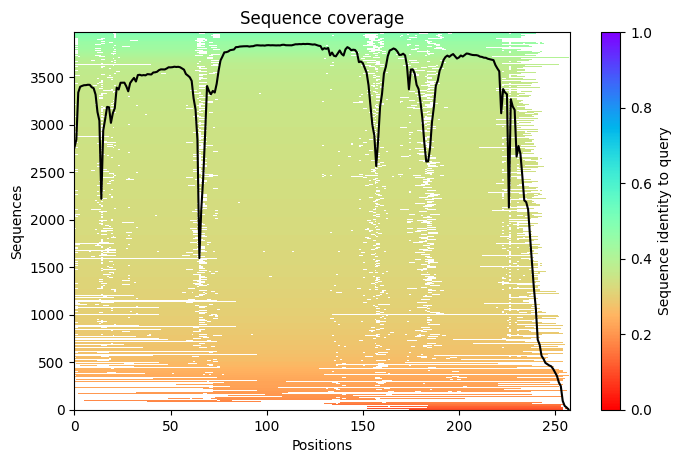

In [ ]:
#@title Search against genetic databases
#@markdown ---
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence","custom_a3m"]
#@markdown - `mmseqs2` - FAST method from [ColabFold](https://github.com/sokrypton/ColabFold)
#@markdown - `single_sequence` - use single sequence input (not recommended, unless a *denovo* design and you dont expect to find any homologous sequences)
#@markdown - `custom_a3m` Upload custom MSA (a3m format)

# tmp directory
prefix = cf.get_hash(sequence)
os.makedirs('tmp', exist_ok=True)
prefix = os.path.join('tmp',prefix)

if msa_method == "mmseqs2":
  a3m_lines = cf.run_mmseqs2(sequence, prefix, filter=True)
  with open(f"{jobname}.a3m","w") as a3m:
    a3m.write(a3m_lines)

elif msa_method == "single_sequence":
  with open(f"{jobname}.a3m","w") as a3m:
    a3m.write(f">{jobname}\n{sequence}\n")

elif msa_method == "custom_a3m":
  print("upload custom a3m")
  msa_dict = files.upload()
  lines = msa_dict[list(msa_dict.keys())[0]].decode().splitlines()
  a3m_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      a3m_lines.append(line)

  with open(f"{jobname}.a3m","w") as a3m:
    a3m.write(a3m_lines)

  if len(msas[0][0]) != len(sequence):
    print("ERROR: the length of msa does not match input sequence")

msa_arr = np.unique(parse_a3m(f"{jobname}.a3m"),axis=0)
total_msa_size = len(msa_arr)
if msa_method == "mmseqs2":
  print(f'\n{total_msa_size} Sequences Found in Total (after filtering)\n')
else:
  print(f'\n{total_msa_size} Sequences Found in Total\n')

if total_msa_size > 1:
  plt.figure(figsize=(8,5),dpi=100)
  plt.title("Sequence coverage")
  seqid = (msa_arr[0] == msa_arr).mean(-1)
  seqid_sort = seqid.argsort()
  non_gaps = (msa_arr != 20).astype(float)
  non_gaps[non_gaps == 0] = np.nan
  plt.imshow(non_gaps[seqid_sort]*seqid[seqid_sort,None],
            interpolation='nearest', aspect='auto',
            cmap="rainbow_r", vmin=0, vmax=1, origin='lower',
            extent=(0, msa_arr.shape[1], 0, msa_arr.shape[0]))
  plt.plot((msa_arr != 20).sum(0), color='black')
  plt.xlim(0,msa_arr.shape[1])
  plt.ylim(0,msa_arr.shape[0])
  plt.colorbar(label="Sequence identity to query",)
  plt.xlabel("Positions")
  plt.ylabel("Sequences")
  #plt.savefig(os.path.join(output_dir,"msa_coverage.png"), bbox_inches = 'tight')
  plt.show()

SE(3) iteration 0 [0.6006 0.6006]
SE(3) iteration 1 [0.672 0.708]
SE(3) iteration 2 [0.728 0.747]
SE(3) iteration 3 [0.7446 0.7725]
SE(3) iteration 4 [0.745  0.7856]
SE(3) iteration 5 [0.7466 0.7935]
SE(3) iteration 6 [0.7485 0.8   ]
SE(3) iteration 7 [0.7505 0.8027]
SE(3) iteration 8 [0.754 0.804]
SE(3) iteration 9 [0.7524 0.8047]
SE(3) iteration 10 [0.751  0.8047]
SE(3) iteration 11 [0.7515 0.8047]
SE(3) iteration 12 [0.751  0.8047]
SE(3) iteration 13 [0.752 0.805]
SE(3) iteration 14 [0.7524 0.805 ]
SE(3) iteration 15 [0.752 0.805]
SE(3) iteration 16 [0.7505 0.805 ]
SE(3) iteration 17 [0.75  0.805]
SE(3) iteration 18 [0.7524 0.805 ]
SE(3) iteration 19 [0.7524 0.805 ]
SE(3) iteration 20 [0.7544 0.805 ]
SE(3) iteration 21 [0.7534 0.805 ]
SE(3) iteration 22 [0.7534 0.805 ]
SE(3) iteration 23 [0.755 0.805]
SE(3) iteration 24 [0.7573 0.805 ]


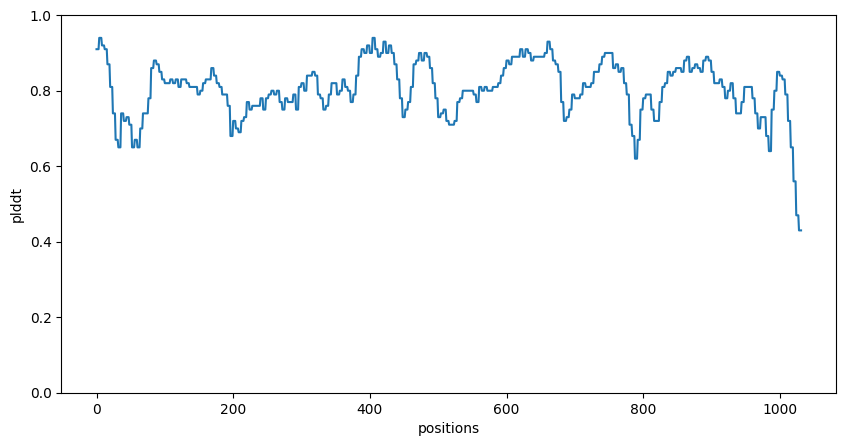

In [ ]:
#@title ## run RoseTTAFold for mainchain and Scrwl4 for sidechain

# make prediction using model
rosettafold.predict(f"{jobname}.a3m",jobname)

# pack sidechains using Scwrl4
plddt = do_scwrl(f"{jobname}.pdb",f"{jobname}.scwrl.pdb")

plt.figure(figsize=(10,5),dpi=100)
plt.plot(plddt)
plt.xlabel("positions")
plt.ylabel("plddt")
plt.ylim(0,1)
plt.show()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

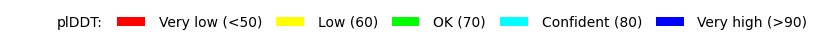

In [ ]:
#@title Display 3D structure {run: "auto"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = True #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
cf.show_pdb(f"{jobname}.scwrl.pdb", show_sidechains, show_mainchains, color, chains=1, vmin=0.5, vmax=0.9).show()

if color == "lDDT": cf.plot_plddt_legend().show()  